In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import celltypist as ct

/orcd/home/002/gokulg/miniforge3/envs/gde/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/orcd/home/002/gokulg/miniforge3/envs/gde/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/orcd/home/002/gokulg/miniforge3/envs/gde/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
cxg = pd.read_csv('/orcd/data/omarabu/001/jiaqilu/project/count_dataset/Vizgen_MERFISH/data/BrainReceptorShowcase/Slice1/Replicate1/cell_by_gene_S1R1.csv')
true_data = np.load('/orcd/data/omarabu/001/tanush20/data/MERFISH/S1R1.npz', allow_pickle=True)
predicted_data = np.load('/orcd/data/omarabu/001/tanush20/data/MERFISH/S1R1_predicted_counts_5.npz', allow_pickle=True)

In [3]:
print([k for k in true_data.keys()])
print([k for k in predicted_data.keys()])

['imgs', 'counts', 'spots', 'x_um', 'y_um', 'annotations', 'visium_simulated', 'cell_type_counts', 'n_cells']
['spots', 'counts']


In [4]:
predicted_counts = predicted_data['counts']

adata = sc.AnnData(X=predicted_counts,
                   obs=pd.DataFrame(index=[f'cell_{i}' for i in range(predicted_counts.shape[0])]),
                   var=pd.DataFrame(index=cxg.columns.tolist()[1:]))

adata

AnnData object with n_obs × n_vars = 73613 × 649

preprocessed
pca done
nn construction done
leiden done
umap done


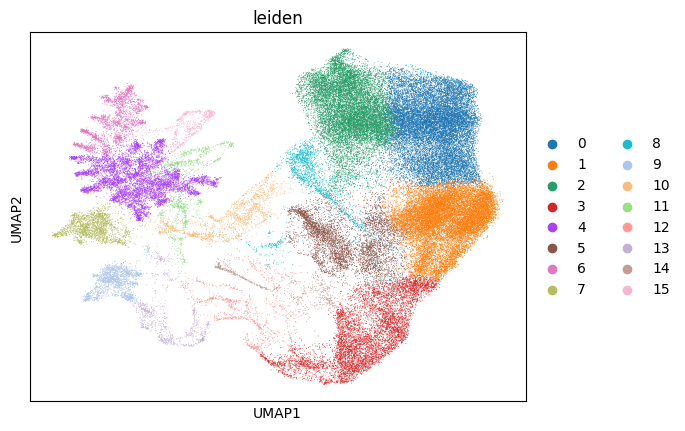

In [5]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
print('preprocessed')
sc.pp.pca(adata, n_comps=50)
print('pca done')
sc.pp.neighbors(adata, n_neighbors=10)
print('nn construction done')
sc.tl.leiden(adata, resolution=0.5)
print('leiden done')
sc.tl.umap(adata)
print('umap done')
sc.pl.umap(adata, color=['leiden'])

In [6]:
sc.tl.rank_genes_groups(adata, groupby="leiden")

dendrogram data not found (using key=dendrogram_leiden). Running `sc.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `sc.tl.dendrogram` independently.


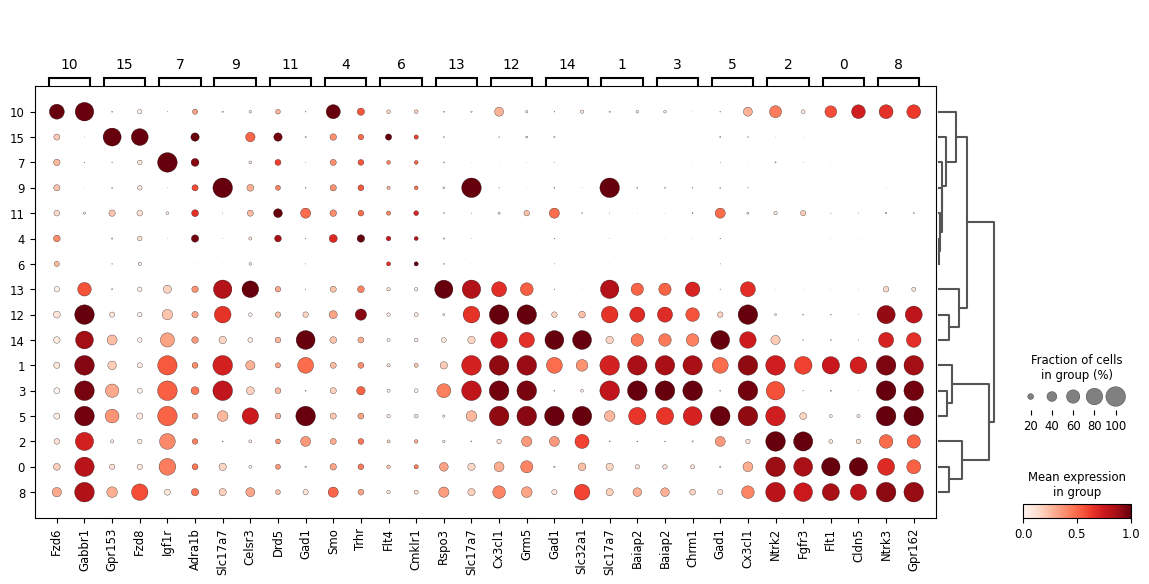

In [7]:
# sc.tl.filter_rank_genes_groups(adata, min_fold_change=1.5)
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=2)

In [8]:
from celltypist import models
models.download_models(model = 'Mouse_Whole_Brain.pkl')

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 59
📂 Storing models in /home/gokulg/.celltypist/data/models
💾 Total models to download: 1
💾 Downloading model [1/1]: Mouse_Whole_Brain.pkl


In [9]:
model = ct.models.Model.load(model="Mouse_Whole_Brain.pkl")
predictions = ct.annotate(adata, model="Mouse_Whole_Brain.pkl", majority_voting=True, over_clustering="leiden")
# convert back to anndata
adata = predictions.to_adata()

🔬 Input data has 73613 cells and 649 genes
🔗 Matching reference genes in the model
🧬 259 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


In [15]:
adata_real = sc.AnnData(X=true_data['counts'],
                   obs=pd.DataFrame(index=[f'cell_{i}' for i in range(true_data['counts'].shape[0])]),
                   var=pd.DataFrame(index=cxg.columns.tolist()[1:]))

In [17]:
sc.pp.normalize_total(adata_real, target_sum=1e4)
sc.pp.log1p(adata_real)
print('preprocessed')
sc.pp.pca(adata_real, n_comps=50)
print('pca done')
sc.pp.neighbors(adata_real, n_neighbors=10)
print('nn construction done')
sc.tl.leiden(adata_real, resolution=0.5)
print('leiden done')

preprocessed
pca done
nn construction done
leiden done


In [18]:
model = ct.models.Model.load(model="Mouse_Whole_Brain.pkl")
predictions = ct.annotate(adata_real, model="Mouse_Whole_Brain.pkl", majority_voting=True, over_clustering="leiden")
# convert back to anndata
adata_real = predictions.to_adata()

🔬 Input data has 78329 cells and 649 genes
🔗 Matching reference genes in the model
🧬 259 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


In [41]:
print(adata_real.obs['predicted_labels'].value_counts().head(10))
print(adata.obs['predicted_labels'].value_counts().head(10))

print(len(adata_real.obs['predicted_labels'].unique()))
print(len(adata.obs['predicted_labels'].unique()))

predicted_labels
327 Oligo NN                 10987
166 MRN Pou3f1 C1ql4 Glut     6527
004 L6 IT CTX Glut            3633
319 Astro-TE NN               3317
006 L4/5 IT CTX Glut          2796
173 PAG Pou4f2 Glut           2780
222 PB Evx2 Glut              2591
030 L6 CT CTX Glut            2578
008 L2/3 IT ENT Glut          2341
062 STR D2 Gaba               1723
Name: count, dtype: int64
predicted_labels
327 Oligo NN                 13023
166 MRN Pou3f1 C1ql4 Glut     5582
330 VLMC NN                   3797
173 PAG Pou4f2 Glut           2809
062 STR D2 Gaba               2455
061 STR D1 Gaba               1988
023 SUB-ProS Glut             1881
222 PB Evx2 Glut              1865
172 PAG Pou4f1 Ebf2 Glut      1852
008 L2/3 IT ENT Glut          1602
Name: count, dtype: int64
278
268


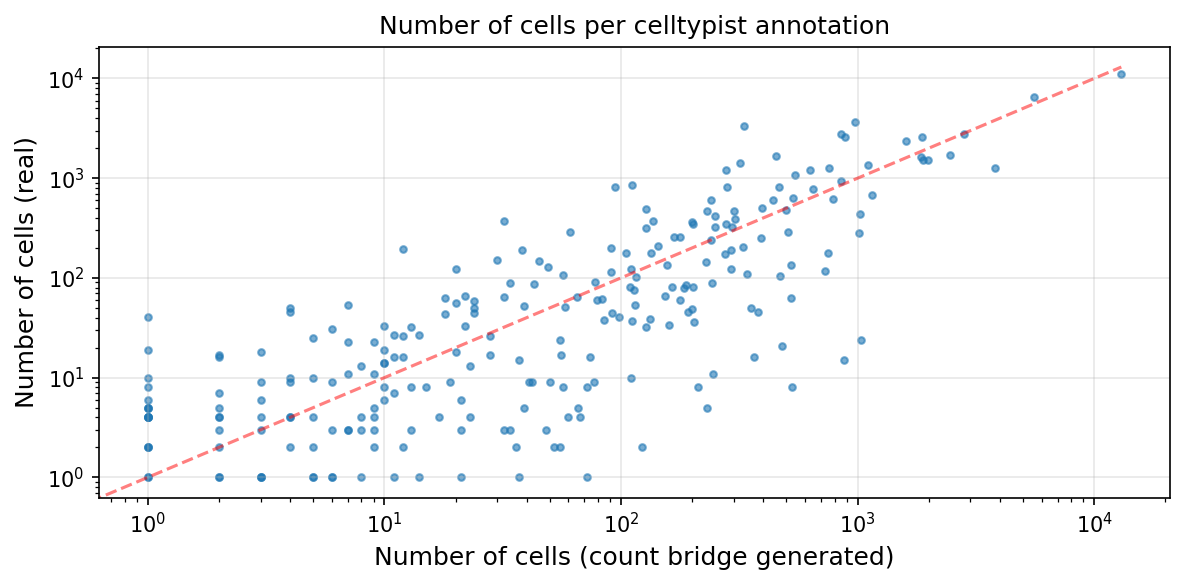

In [36]:
# Get cell type counts for both datasets
real_counts = adata_real.obs['predicted_labels'].value_counts()
pred_counts = adata.obs['predicted_labels'].value_counts()

# Create a dataframe with both counts
cell_types = set(real_counts.index) | set(pred_counts.index)
comparison_df = pd.DataFrame({
    'real': [real_counts.get(ct, 0) for ct in cell_types],
    'predicted': [pred_counts.get(ct, 0) for ct in cell_types],
    'cell_type': list(cell_types)
})

# Create scatter plot
plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(comparison_df['predicted'], comparison_df['real'], alpha=0.6, s=10)

# Add diagonal line for reference (perfect prediction)
max_val = max(comparison_df[['predicted', 'real']].max())
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label=None)

plt.xlabel('Number of cells (count bridge generated)', fontsize=12)
plt.ylabel('Number of cells (real)', fontsize=12)
# plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Number of cells per celltypist annotation')

# Optionally annotate points with cell type names
# for idx, row in comparison_df.iterrows():
#     if row['predicted'] > 1000 and row['real'] > 1000:
#         plt.annotate(row['cell_type'], 
#                     (row['predicted'], row['real']), 
#                     fontsize=8, 
#                     alpha=0.7,
#                     xytext=(5, 5), 
#                     textcoords='offset points')

plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()